--- Consolidating Monthly Returns Data ---

Combined DataFrame shape: (175, 11)
Data covers: 2010-12 to 2025-06

Annualized Expected Returns (from historical monthly means):
_IRX      41.470694
AGG        0.016089
LQD        0.032802
HYG        0.048363
IWDA.L     0.114788
EEM        0.041700
VNQI       0.051137
DBC        0.017400
GLD        0.067647
IGF        0.082979
IUKP.L     0.028408
dtype: float64

Annualized Covariance Matrix:
             _IRX       AGG       LQD       HYG    IWDA.L       EEM      VNQI  \
_IRX    30.910139  0.012164  0.029172  0.035578  0.108280  0.118467  0.106876   
AGG      0.012164  0.010352  0.012697  0.012084  0.015228  0.017641  0.018306   
LQD      0.029172  0.012697  0.016527  0.015707  0.020017  0.023088  0.023788   
HYG      0.035578  0.012084  0.015707  0.018360  0.024128  0.026620  0.026204   
IWDA.L   0.108280  0.015228  0.020017  0.024128  0.038499  0.038809  0.037681   
EEM      0.118467  0.017641  0.023088  0.026620  0.038809  0.053344  0.046

<ipython-input-1-2a7406f8b80e>:150: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  efficient_frontier = pd.concat([efficient_frontier, pd.DataFrame([efficient_portfolio])], ignore_index=True)



Approximate Efficient Frontier (first 5 points):
   Volatility    Return  Sharpe_Ratio      _IRX       AGG       LQD       HYG  \
0    0.140977  0.471861      3.347088  0.010587  0.224104  0.205195  0.144880   
1    0.167040  0.723449      4.330988  0.016541  0.222078  0.129797  0.034874   
2    0.185282  0.975744      5.266274  0.022428  0.187271  0.146819  0.157416   
3    0.203712  1.175545      5.770616  0.027557  0.227191  0.129913  0.129380   
4    0.221371  1.323115      5.976922  0.030959  0.170206  0.117505  0.138592   

     IWDA.L       EEM      VNQI       DBC       GLD       IGF    IUKP.L  
0  0.009593  0.046746  0.025384  0.059032  0.051951  0.004709  0.217820  
1  0.019136  0.035963  0.072360  0.101814  0.101850  0.079814  0.185773  
2  0.085825  0.000933  0.045023  0.019800  0.179814  0.020145  0.134526  
3  0.018102  0.005605  0.010707  0.210234  0.130987  0.000725  0.109600  
4  0.049224  0.007989  0.013888  0.139987  0.114916  0.052256  0.164477  


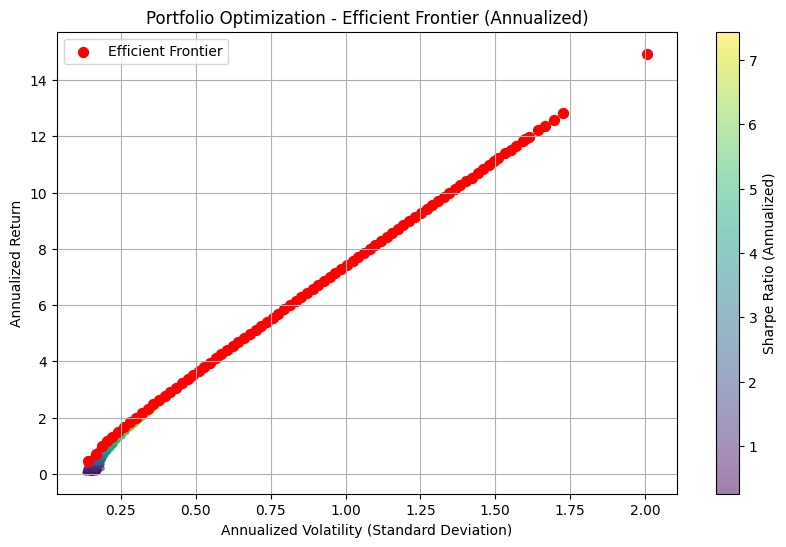

In [ ]:
import pandas as pd
import numpy as np
import os
from scipy.optimize import minimize
import matplotlib.pyplot as plt

all_asset_classes_for_correlation = [
    '_IRX_monthly_returns_GBP.csv',
    'AGG_monthly_returns_GBP.csv',
    'LQD_monthly_returns_GBP.csv',
    'HYG_monthly_returns_GBP.csv',
    'IWDA.L_monthly_returns_GBP.csv',
    'EEM_monthly_returns_GBP.csv',
    'VNQI_monthly_returns_GBP.csv',
    'DBC_monthly_returns_GBP.csv',
    'GLD_monthly_returns_GBP.csv',
    'IGF_monthly_returns_GBP.csv',
    'IUKP.L_monthly_returns.csv' # This one is already in GBP
]

def create_combined_returns_df(file_list: list):
    all_returns = {}
    for filename in file_list:
        try:
            ticker_name = filename.replace('_monthly_returns_GBP.csv', '').replace('_monthly_returns.csv', '')

            df = pd.read_csv(filename, index_col='Date', parse_dates=True)
            if 'Monthly_Return' in df.columns:
                all_returns[ticker_name] = df['Monthly_Return']
            else:
                print(f"Warning: No recognised return column in {filename}. Skipping.")
        except FileNotFoundError:
            print(f"Error: File not found for {filename}. Skipping.")
        except Exception as e:
            print(f"Error processing {filename}: {e}")

    # Combine all series into a single DataFrame
    combined_df = pd.DataFrame(all_returns)
    
    ##Check the below
    initial_rows = len(combined_df)
    combined_df.dropna(inplace=True)
    final_rows = len(combined_df)

    if initial_rows != final_rows:
        print(f"Warning: Dropped {initial_rows - final_rows} rows due to missing data for some assets.")
        print(f"Common data period: {combined_df.index.min().strftime('%Y-%m')} to {combined_df.index.max().strftime('%Y-%m')}")

    return combined_df

# Create the combined DataFrame
print("--- Consolidating Monthly Returns Data ---")
combined_monthly_returns_gbp = create_combined_returns_df(all_asset_classes_for_correlation)

if combined_monthly_returns_gbp.empty:
    print("No data to proceed. Please check your CSV files and paths.")
    exit()

print(f"\nCombined DataFrame shape: {combined_monthly_returns_gbp.shape}")
print(f"Data covers: {combined_monthly_returns_gbp.index.min().strftime('%Y-%m')} to {combined_monthly_returns_gbp.index.max().strftime('%Y-%m')}")

# Calculate the MVO inputs from historical data
num_months_in_year = 12

# 1. Expected Returns (Annualized)
# Convert monthly mean to annualized mean
expected_returns_annualized = (1 + combined_monthly_returns_gbp.mean())**num_months_in_year - 1
print("\nAnnualized Expected Returns (from historical monthly means):")
print(expected_returns_annualized)

# 2. Covariance Matrix (Annualized)
# Multiply monthly covariance by 12 to annualize variance, assuming i.i.d. returns
covariance_matrix_annualized = combined_monthly_returns_gbp.cov() * num_months_in_year
print("\nAnnualized Covariance Matrix:")
print(covariance_matrix_annualized)

# 3. Standard Deviations (Annualized)
# For standard deviation, it's sqrt(annualized variance)
std_devs_annualized = np.sqrt(np.diag(covariance_matrix_annualized))
std_devs_annualized = pd.Series(std_devs_annualized, index=combined_monthly_returns_gbp.columns)
print("\nAnnualized Standard Deviations (Volatility):")
print(std_devs_annualized)

# Define the number of assets
num_assets = len(expected_returns_annualized)
asset_names = expected_returns_annualized.index.tolist()

# Define functions for portfolio return, volatility, and negative Sharpe Ratio (for optimization)
def portfolio_return(weights, expected_returns):
    return np.sum(expected_returns * weights)

def portfolio_volatility(weights, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

# We need to maximize return for a given risk, or minimize risk for a given return.
# For simplicity, we'll plot a frontier by minimizing volatility for a range of target returns.
# Or, we can generate many random portfolios and filter for the efficient ones.
# Given your context, let's use the random portfolio generation for visualization,
# which is often more intuitive for seeing the frontier directly.

num_portfolios = 50000 # Number of random portfolios to generate

# Store results for plotting
results = np.zeros((3, num_portfolios)) # Row 0: Vol, Row 1: Return, Row 2: Sharpe Ratio
all_weights = np.zeros((num_portfolios, num_assets)) # Store all weights

print(f"\n--- Generating {num_portfolios} Random Portfolios for MVO ---")

for i in range(num_portfolios):
    weights = np.random.random(num_assets)
    weights /= np.sum(weights) # Normalize weights to sum to 1
    
    p_return = portfolio_return(weights, expected_returns_annualized.values)
    p_volatility = portfolio_volatility(weights, covariance_matrix_annualized.values)
    
    results[0,i] = p_volatility
    results[1,i] = p_return
    results[2,i] = p_return / p_volatility # Sharpe Ratio (assuming 0 risk-free rate for simplicity)
    all_weights[i,:] = weights

# Convert results to a DataFrame
columns = ['Volatility', 'Return', 'Sharpe_Ratio'] + asset_names
portfolios_df = pd.DataFrame(data=np.c_[results.T, all_weights], columns=columns)

print("Sample of generated portfolios:")
print(portfolios_df.head())

# Find the Efficient Frontier (approximate from random portfolios)
# For each level of volatility, find the portfolio with the highest return
# This is a brute-force way; proper MVO involves optimization, but this gives a good visual.
# Sort by volatility, then by return for each volatility bucket.
portfolios_df_sorted = portfolios_df.sort_values(by=['Volatility', 'Return'], ascending=[True, False])

# Discretize volatility to find the frontier
# Group by small volatility bins and pick the max return in each bin
volatility_bins = np.linspace(portfolios_df_sorted['Volatility'].min(), portfolios_df_sorted['Volatility'].max(), 100)
efficient_frontier = pd.DataFrame(columns=portfolios_df.columns)

for i in range(len(volatility_bins) - 1):
    bin_start = volatility_bins[i]
    bin_end = volatility_bins[i+1]
    
    # Portfolios within this volatility bin
    bin_portfolios = portfolios_df_sorted[(portfolios_df_sorted['Volatility'] >= bin_start) & 
                                          (portfolios_df_sorted['Volatility'] < bin_end)]
    
    if not bin_portfolios.empty:
        # Find the portfolio with the max return in this bin
        efficient_portfolio = bin_portfolios.loc[bin_portfolios['Return'].idxmax()]
        efficient_frontier = pd.concat([efficient_frontier, pd.DataFrame([efficient_portfolio])], ignore_index=True)

# Remove duplicates if any (due to binning) and sort by volatility
efficient_frontier.drop_duplicates(subset=['Volatility'], inplace=True)
efficient_frontier.sort_values(by='Volatility', inplace=True)

print("\nApproximate Efficient Frontier (first 5 points):")
print(efficient_frontier.head())

# Plotting the efficient frontier


plt.figure(figsize=(10, 6))
plt.scatter(portfolios_df['Volatility'], portfolios_df['Return'], c=portfolios_df['Sharpe_Ratio'], cmap='viridis', s=10, alpha=0.5)
plt.colorbar(label='Sharpe Ratio (Annualized)')
plt.scatter(efficient_frontier['Volatility'], efficient_frontier['Return'], color='red', marker='o', s=50, label='Efficient Frontier')
plt.title('Portfolio Optimization - Efficient Frontier (Annualized)')
plt.xlabel('Annualized Volatility (Standard Deviation)')
plt.ylabel('Annualized Return')
plt.grid(True)
plt.legend()
plt.show()